# Resnik (1996)

* **Statistic**: Selectional Preference Strength
* **Corpus**:
    * Brown (NLTK)
    * WordNet (NLTK)
* **Parsing**:
    * Type: Dependency
    * Library: Spacy
* **Categorization**
    * Nouns are categorized by their WordNet synsets.

### A. Math

* **Main Function**: $S(p_i) = D_{KL}(Pr(c|p_i)||Pr(c)) = \sum_cPr(c|p_i)log\frac{Pr(c|p_i)}{Pr(c)}$ (cf. Resnik 1996:136)


* **Probability of a Synset**: $Pr(c) = \sum_{arg\in c} Pr(arg)$


* **Probability of a Synset Given Predicate**: $Pr(c|p_i) = \sum_{arg\in c} Pr(arg|p_i)$

### B. Synset Retriever (WordNet)

In [1]:
from nltk.corpus import wordnet as wn

In [13]:
class SynsetRetriever:
    
    def __init__(self):
        return
    
    def related_synsets(self, words):
        """
        FUNCTION: 
            given a set of words, return all the synsets in which the word appears.
        ARGS:
            _words_: a list of words in strings.
        """
        synsets = []
        for word in words:
            synsets += wn.synsets(word)
        return list(set(synsets))
    
    def summary(self, word):
        """
        FUNCTION:
            given a word, prints: its synsets, pos + synset name + lemmas in synsets.
        ARGS:
            _word_: a word in string.
        """
        synsets = wn.synsets(word)
        print "Synsets:"
        print
        print synsets
        print
        print "Pos & Names & Lemmas: "
        print
        for synset in synsets:
            print synset.pos(), '|', synset.name(), '|', synset.lemma_names()         
 

In [14]:
sr = SynsetRetriever()

In [15]:
sr.summary('dog')

Synsets:

[Synset('dog.n.01'), Synset('frump.n.01'), Synset('dog.n.03'), Synset('cad.n.01'), Synset('frank.n.02'), Synset('pawl.n.01'), Synset('andiron.n.01'), Synset('chase.v.01')]

Pos & Names & Lemmas: 

n | dog.n.01 | [u'dog', u'domestic_dog', u'Canis_familiaris']
n | frump.n.01 | [u'frump', u'dog']
n | dog.n.03 | [u'dog']
n | cad.n.01 | [u'cad', u'bounder', u'blackguard', u'dog', u'hound', u'heel']
n | frank.n.02 | [u'frank', u'frankfurter', u'hotdog', u'hot_dog', u'dog', u'wiener', u'wienerwurst', u'weenie']
n | pawl.n.01 | [u'pawl', u'detent', u'click', u'dog']
n | andiron.n.01 | [u'andiron', u'firedog', u'dog', u'dog-iron']
v | chase.v.01 | [u'chase', u'chase_after', u'trail', u'tail', u'tag', u'give_chase', u'dog', u'go_after', u'track']


### B. Dependency Matrix (Brown + Spacy)

In [16]:
from nltk.corpus import brown
from spacy.en import English

In [19]:
import random
import numpy as np
from collections import Counter, defaultdict

In [18]:
from nltk.stem import PorterStemmer
porter = PorterStemmer()

In [26]:
def dependency_matrix():
    """
    FUNCTION:
        computes a dependency matrix with: 
          - rows: predicates
          - cols: arguments
        returns 
          - argument set (for retrieving relevant synsets later)
          - pred-to-index dictionary
          - arg-to-index dictionary
          - dependency matrix
    """
    # extract info from corpus
    sents = [' '.join(sent) for sent in brown.sents()]
    tagged_words = brown.tagged_words(tagset='universal')
    w2t = defaultdict(str,{w:t for w,t in tagged_words})
    
    # parser corpus
    parser = English()
    parsed_corpus = [parser(sent) for sent in sents]
    
    # find pred-arg pairs
    pred_arg_pairs = [(token.head.orth_,token.orth_)
                      for sent in parsed_corpus
                      for token in sent
                      if token.dep_=='dobj' and w2t[token.head.orth_]=='VERB']
    arg_set = list({arg.lower() for pred,arg in pred_arg_pairs})
    
    # "standardize" preds and args by stemming
    pred_arg_pairs = [(porter.stem(pred).lower(),porter.stem(arg)) 
                      for pred,arg in pred_arg_pairs]
    
    # build pred/arg-to-index dictionaries
    pred_vocab = list({pred for pred,arg in pred_arg_pairs})
    arg_vocab = list({arg for pred,arg in pred_arg_pairs})
    pred2i = defaultdict(int, {p:i for i,p in enumerate(pred_vocab)})
    arg2i = defaultdict(int, {a:i for i,a in enumerate(arg_vocab)})
    
    # build dependency matrix
    dep_m = np.zeros((len(pred_vocab),len(arg_vocab)))
    for pred,arg in pred_arg_pairs:
        dep_m[pred2i[pred]][arg2i[arg]] += 1    
    
    return arg_set, pred2i, arg2i, dep_m 
    

In [27]:
%%time
arg_set, pred2i, arg2i, dep_m = dependency_matrix()

CPU times: user 2min, sys: 2.54 s, total: 2min 2s
Wall time: 2min 3s


### C. Selectional Preference Strength

In [ ]:
from __future__ import division

In [40]:
class SPS:
    
    def __init__(self, arg_set, pred2i, arg2i, dep_m, synset_retriever):
        
        synsets = synset_retriever.related_synsets(arg_set)
        total_freq = dep_m.sum()
        porter = PorterStemmer()
        
        Pr_arg = lambda arg: sum(dep_m[:,arg2i[arg]]) / total_freq
        Pr_c = lambda c: sum(Pr_arg(arg) for arg in get_words(c)) 
        get_words = lambda synset: [porter.stem(w) for w in synset.lemma_names()]
        log = lambda x: np.log(x) if x!=0 else np.log(1e-20)
        
        def Pr_c_given_p(c,p):
            args = get_words(c)
            total_p_freq = sum(dep_m[pred2i[p],:])
            return sum(dep_m[pred2i[p]][arg2i[arg]]/total_p_freq for arg in args)

        self.sps = lambda p: sum(Pr_c_given_p(c,p)*log(Pr_c_given_p(c,p)/Pr_c(c)) 
                                 for c in synsets)


In [41]:
%%time
sps = SPS(arg_set, pred2i, arg2i, dep_m, sr)

CPU times: user 231 ms, sys: 6.77 ms, total: 238 ms
Wall time: 235 ms


In [46]:
sps.sps('push')

22.254626428061584

### D. Mini Experiment

* **pour**, **drink** and **pack** are strongly selective words in terms of the set of direct object (Resnik 1996:138), whereas **give**, **make** and **have** are selectionally more promiscuous.

* Therefore, the former words are expected to have higher SPS against the latter words.

* **NB**: The numbers I got here are different from that in the original work, most likely due to use of updated corpus (Brown and WordNet), however the relative SPS of the words is solid.

** a. SPS Comparison **

In [45]:
print "Selection Preference Strength"
print 
print "'pour': ", sps.sps('pour')
print "'drink': ", sps.sps('drink')
print "'pack': ", sps.sps('pack')
print
print "'give': ", sps.sps('give')
print "'make': ", sps.sps('make')
print "'have': ", sps.sps('have')

 Selection Preference Strength

'pour':  30.7441715022
'drink':  26.5501401461
'pack':  28.5965381572

'give':  16.3344065669
'make':  18.2618394795
'have':  8.32228661623


** b. Selection Preference Profile ** (cf. Resnik 1996:139,fig.2)

* I show SP Profile using probability distributions computed on raw counts rather than *selectional association* between predicates and synsets. This saves the computational cost while demonstrates basically the same pattern.
* Different words are used here to show an even larger contrast between *selectionally-picky* and *selectionally-promiscuous* predicates.

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

In [69]:
# COMPUTE SELECTIONAL PROBABILITY DISTRIBUTIONS
prs_pour = dep_m[pred2i['pour']] / sum(dep_m[pred2i['pour']])
prs_have = dep_m[pred2i['have']] / sum(dep_m[pred2i['have']])

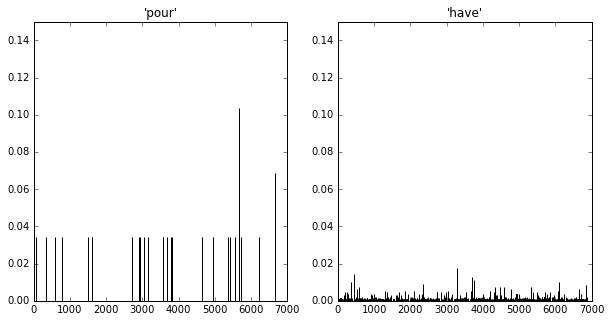

In [77]:
fig = plt.figure(figsize=(10,5))
ax = plt.subplot(121)
ax.set_title("'pour'")
ax.set_ylim(0,0.15)
ax.bar(np.arange(len(prs_pour)), prs_pour)
ax = plt.subplot(122)
ax.set_title("'have'")
ax.set_ylim(0,0.15)
ax.bar(np.arange(len(prs_have)), prs_have)
plt.show()

**Comments**: Clearly 'pour' has a more concentrated "selectional mass" whereas 'have' selects a much wider range of arguments.